In [263]:
%matplotlib inline
import pandas as pd
import os
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import datetime
import sys
import seaborn as sns
import scipy
from sqlalchemy import create_engine
from sklearn.decomposition import PCA

# look for utilities in P drive first, then local
if os.path.isdir('P:/mikePandas'):
    sys.path.append('P:/mikePandas')
elif os.path.isdir('./util'):
    sys.path.append('./util')
from blpwrap import *
from seabornwrap import *

### Data Parse From Excel

In [44]:
# Check if peer universe db has been created, otws, create the db from excel file
if not os.path.exists('./fund_peer_universe.db'):
    
    # MorningstarPeerData has peer holdings and weights for both allocator and lifesmart
    df = pd.DataFrame()
    xl = pd.ExcelFile('./MorningstarPeerData.xlsx')
    
    # Using Panda's ExceLFile module to read peer data
    for k in range(0, len(xl.sheet_names)):
        # iterate through each worksheet, where worksheet.name = fund name
        ws = xl.parse(k, header=0, parse_cols='A:C')
        ws['Portfolio'] = [xl.sheet_names[k]] * len(ws)
        df = df.append(ws)
    
    # Initializes database with name 'fund_peer_universe.db' 
    disk_engine = create_engine('sqlite:///fund_peer_universe.db')
    
    # Create db table 'Portfolios', append data if it does not exist
    df.to_sql('Portfolios', disk_engine, if_exists='replace', index=0)
    

### SQL Query

In [155]:
# Get Distinct Portfolios to run PCA
ports = pd.read_sql_query('SELECT DISTINCT portfolio FROM Portfolios', disk_engine).ix[:,0]

0         Franklin LifeSmart 2025 A
1    Franklin Moderate Allocation A
2    Hartford Moderate Allocation A
3     Invesco Moderate Allocation A
4     JHancock Lifestyle Balanced A
5        JPM SmartRetirement 2025 A
6      JPMorgan Investor Balanced A
7         MFS Moderate Allocation A
Name: Portfolio, dtype: object

In [233]:
def get_port_memb(db_engine, port_name, dropNa=False):
    qrystr = 'SELECT * FROM Portfolios where portfolio = "' + port_name + '"'
    qryout = pd.read_sql_query(qrystr, disk_engine)
    if dropNa is True:
        qryout = qryout.dropna(how='any')
    return (qryout.Name, qryout.Ticker)

In [236]:
[name, ticker] = get_port_memb(disk_engine, ports[1], dropNa=True)

u'FTTRX'

### Compute PCA

https://github.com/teddyroland/python-biplot/blob/master/biplot.py   
https://sukhbinder.wordpress.com/2015/08/05/biplot-with-python/


In [261]:
# setup dates and security list
start_dt = '2013-10-01'
end_dt = '2015-10-01'
slist = ticker.values + ' Equity'

# retrieve bbg data
tbl_px = blp_wrapper(slist, start_dt, end_dt, periodicitySelection='daily')

# calc return, cov
tbl_ret = tbl_ret.drop_duplicates()
tbl_ret = tbl_ret.dropna(how='all')
tbl_ret = tbl_ret.rename(columns=dict(zip(slist, names)))

tbl_cor = tbl_ret.corr()
tbl_cor = tbl_cor.fillna(0)

connecting to blp session...
...success!
sending request...
receiving request...
AAXJ Equity  has  505
FSERX Equity  has  505
FIFRX Equity  has  505
FCAPX Equity  has  505
IVE Equity  has  505
FILRX Equity  has  505
FTTRX Equity  has  505
FUFRX Equity  has  505
DXJ Equity  has  505
FRISX Equity  has  505
FGKNX Equity  has  377
FLRRX Equity  has  377
FRBRX Equity  has  504
FASRX Equity  has  471
FDTRX Equity  has  505
FCWRX Equity  has  505
FMEUX Equity  has  505
FOPPX Equity  has  505
FSMLX Equity  has  505
FPELX Equity  has  377
FTSD Equity  has  258
FTFGX Equity  has  505
CIU Equity  has  505
IGF Equity  has  505
FGORX Equity  has  505
IVV Equity  has  505
FEMDX Equity  has  505
FFMRX Equity  has  505
...all data have been received!
# of securities retrieved:  28


In [419]:
def biplot(CorrMat):
    pca = PCA(n_components=3).fit(CorrMat)
    print pca.explained_variance_ratio_.sum() * 100
    
    # arrow plot -> loadings
    load1 = pca.components_[0]
    load2 = pca.components_[1]
    load3 = pca.components_[2]
    
    # scatter plot -> scores
    score1 = pca.transform(tbl_cor)[:,0]
    score2 = pca.transform(tbl_cor)[:,1]
    score3 = pca.transform(tbl_cor)[:,2]
    
    scale1 = 1.0/(score1.max() - score1.min())
    scale2 = 1.0/(score2.max() - score2.min())
    scale3 = 1.0/(score3.max() - score3.min())
    
    n = len(CorrMat)
    
    plt.figure(figsize=(18,6))
    
    ax1 = plt.subplot(121)
    #ax1.scatter(score1*scale1, score2*scale2)
    for i in range(n):
        ax1.arrow(0, 0, load1[i], load2[i], color='r', alpha=0.5)
    ax1.set_xlabel("PC1")
    ax1.set_ylabel("PC2")
    ax1.set_xlim(load1.min()*1.5,load1.max()*1.5)
    ax1.set_ylim(load2.min()*1.5,load2.max()*1.5)
    ax1.grid( linestyle='-', color='0.65')
    
    ax2 = plt.subplot(122)
    #ax1.scatter(score1*scale1, score2*scale2)
    for i in range(n):
        ax2.arrow(0, 0, load2[i], load3[i], color='r', alpha=0.5)
    ax2.set_xlabel("PC2")
    ax2.set_ylabel("PC3")
    ax2.set_xlim(load2.min()*1.3,load2.max()*1.3)
    ax2.set_ylim(load3.min()*1.3,load3.max()*1.3)
    ax2.grid( linestyle='-', color='0.65')
    
    
    

89.418761582


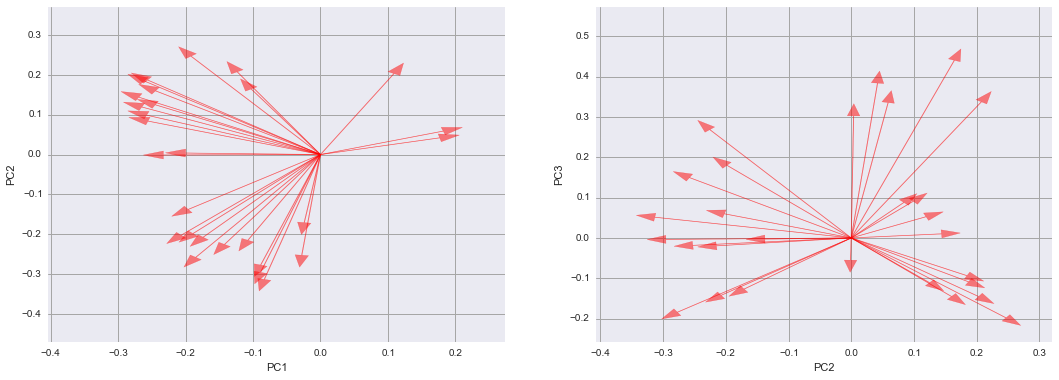

In [420]:
biplot(tbl_cor)

28L